In [1]:
!pip install -q transformers accelerate torch

In [ ]:
# hardcode with keys and without translator

import torch
from transformers import AutoTokenizer, AutoModelForCausalLM

device = "cuda" if torch.cuda.is_available() else "cpu"

bp_tok = AutoTokenizer.from_pretrained("alibaba-pai/pai-bloom-1b1-text2prompt-sd-v2")
bp = AutoModelForCausalLM.from_pretrained(
    "alibaba-pai/pai-bloom-1b1-text2prompt-sd-v2"
).to(device).eval()

BP_TEMPLATE = (
    "Converts a simple image description into a prompt. "
    "Prompts are formatted as multiple related tags separated by commas, "
    "you can use () to increase weight and [] to decrease weight. "
    "Add appropriate words to make the image more aesthetically pleasing, "
    "but keep correlated with the input.\n"
    "### Input: {raw_prompt}\n### Output:"
)

@torch.inference_mode()
def enhance_with_beautifulprompt(text_en: str, max_new_tokens=196) -> str:
    ids = bp_tok.encode(BP_TEMPLATE.format(raw_prompt=text_en), return_tensors="pt").to(device)
    out = bp.generate(
        ids,
        max_new_tokens=max_new_tokens,
        do_sample=True, temperature=0.9, top_k=50, top_p=0.95,
        repetition_penalty=1.1, num_return_sequences=1
    )
    return bp_tok.batch_decode(out[:, ids.size(1):], skip_special_tokens=True)[0].strip()

from transformers import AutoModelForCausalLM as CausalLM, AutoTokenizer as AutoTok

promptist = CausalLM.from_pretrained("microsoft/Promptist").to(device).eval()
ptok = AutoTok.from_pretrained("gpt2")
ptok.pad_token = ptok.eos_token
ptok.padding_side = "left"

@torch.inference_mode()
def enhance_with_promptist(text_en: str, beams=8, max_new_tokens=75) -> str:
    prefix = text_en.strip() + " Rephrase:"
    inp = ptok(prefix, return_tensors="pt").to(device)
    out = promptist.generate(
        **inp, do_sample=False, num_beams=beams, num_return_sequences=1,
        max_new_tokens=max_new_tokens, eos_token_id=ptok.eos_token_id,
        pad_token_id=ptok.eos_token_id, length_penalty=-1.0
    )
    txt = ptok.decode(out[0], skip_special_tokens=True)
    return txt.replace(prefix, "").strip()

HOLIDAY_SEEDS = {
    # RU keys
    "8 марта": "International Women's Day postcard with pink roses, hearts, satin ribbon, pastel gradient, glitter sparkles, no text",
    "женский день": "International Women's Day postcard with pink roses, hearts, satin ribbon, pastel gradient, glitter sparkles, no text",
    "день святого валентина": "Valentine's Day postcard with big pink heart, red roses, lace border, cute plush bear, glitter sparkles, no text",
    "валентин": "Valentine's Day postcard with big pink heart, red roses, lace border, cute plush bear, glitter sparkles, no text",
    "пасха": "Easter postcard scene with basket of decorated eggs, white lilies, willow branches, pastel pink and green, glitter sparkles, no text",
    "новый год": "New Year greeting postcard with snowy fir branches, golden ornaments, fireworks bokeh, red ribbon bow, glitter sparkles, no text",
    "рождество": "Christmas postcard with red poinsettias, pine cones, golden bells, warm candlelight, snowflakes bokeh, glitter sparkles, no text",
    "день рождения": "Birthday postcard with cake, strawberries, candles, balloons, confetti, pastel gradient background, glitter sparkles, no text",
    "1 сентября": "Back to school postcard with bouquet of asters, school bell, lined paper texture, golden ribbon, warm bokeh, no text",

    # EN keys
    "international women's day": "International Women's Day postcard with pink roses, hearts, satin ribbon, pastel gradient, glitter sparkles, no text",
    "valentine's day": "Valentine's Day postcard with big pink heart, red roses, lace border, cute plush bear, glitter sparkles, no text",
    "easter": "Easter postcard scene with basket of decorated eggs, white lilies, willow branches, pastel pink and green, glitter sparkles, no text",
    "new year": "New Year greeting postcard with snowy fir branches, golden ornaments, fireworks bokeh, red ribbon bow, glitter sparkles, no text",
    "christmas": "Christmas postcard with red poinsettias, pine cones, golden bells, warm candlelight, snowflakes bokeh, glitter sparkles, no text",
    "birthday": "Birthday postcard with cake, strawberries, candles, balloons, confetti, pastel gradient background, glitter sparkles, no text",
    "back to school": "Back to school postcard with bouquet of asters, school bell, lined paper texture, golden ribbon, warm bokeh, no text",
}

def pick_seed(user_text: str) -> str:
    key = user_text.strip().lower()
    if key in ("8 марта", "8е марта", "восьмое марта"):
        key = "8 марта"
    return HOLIDAY_SEEDS.get(key, f"postcard for {user_text} with fitting symbols, flowers, ribbon, pastel gradient, glitter sparkles, no text")

def holiday_to_prompt(user_text: str, engine="beautiful") -> str:
    base = pick_seed(user_text)
    if engine == "beautiful":
        try:
            return enhance_with_beautifulprompt(base)
        except Exception:
            return enhance_with_promptist(base)
    else:
        p = enhance_with_promptist(base)
        return p if p.lower() != base.lower() else enhance_with_beautifulprompt(base)

tests = ["March 8", "New Year", "Easter", "Valentine's Day", "Birthday"]
for t in tests:
    out = holiday_to_prompt(t, engine="beautiful")
    print(f"\n[{t}] →\n{out}\n")



[March 8] →
(best quality), (masterpiece:1.2), absurdres, (realistic:1.5), postcard of (March 8:8), no humans, fitting symbols, flowers, ribbon, pastel gradient, glitter sparkles, pink bowtie, green sweater, white skirt, grey jacket, flat chest, long hair


[New Year] →
(masterpiece:1.2), (best quality:1.2), New Year greetings, snowing branch, fir trees, golden branches, elegant, high detail, extremely detailed, furious golden branches, snowflakes, golden chains, (high detailed fur:1.2), snowflakes, (glitter:1.3), fireworks, bokeh, glow, red ribbon bow, bowtie, gloves, (no text:1.2)


[Easter] →
(masterpiece), best quality, ultra-detailed, original, beautiful, extremely detailed wallpaper, (Easter Post Card Scene:1.5), Basket of decorated eggs, white lilies, willow branches, pastel pink and green, Glitter sparkles, No text, Wallpaper in high resolution, tft Laptop or desktop


[Valentine's Day] →
(best quality:1.2), (masterpiece:1.3), Post Card, (big pink heart:1.5), (red roses:1.4), 

In [ ]:
enhanced = holiday_to_prompt("8 марта")
print(enhanced)


Postcard of international women day, pink roses on black cardboard tube, gold butterfly in frame, white background, heart-shaped letters to the top, satin ribbon, pastel gradient, glitter sparkles, embellished with a few roses, very detailed, lovely, minneapolis


In [2]:
# with translator

import re, torch
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM, AutoModelForCausalLM

device = "cuda" if torch.cuda.is_available() else "cpu"

ruen_tok = AutoTokenizer.from_pretrained("Helsinki-NLP/opus-mt-ru-en")
ruen_mt  = AutoModelForSeq2SeqLM.from_pretrained("Helsinki-NLP/opus-mt-ru-en").to(device).eval()

@torch.inference_mode()
def ru2en(text: str) -> str:
    enc = ruen_tok(text, return_tensors="pt").to(device)
    out = ruen_mt.generate(**enc, max_new_tokens=96)
    return ruen_tok.batch_decode(out, skip_special_tokens=True)[0].strip()

bp_tok = AutoTokenizer.from_pretrained("alibaba-pai/pai-bloom-1b1-text2prompt-sd-v2")
bp_llm = AutoModelForCausalLM.from_pretrained("alibaba-pai/pai-bloom-1b1-text2prompt-sd-v2").to(device).eval()

SAFE_TEMPLATE = (
    "Rewrite the short holiday description into a Stable Diffusion prompt for a festive POSTCARD.\n"
    "Rules:\n"
    "- Focus on holiday symbols, flowers, hearts, ribbons, candles, fireworks, snow, eggs, lilies, willow, etc.\n"
    "- Keep it cheerful, high saturation, pastel gradients, glitter sparkles.\n"
    "- Must include: 'postcard', 'no text'.\n"
    "- FORBIDDEN: artist names, camera brands, NSFW, body/anatomy terms, 'masterpiece', '8k', 'absurdres', 'by ...'.\n"
    "- Output: comma-separated short tags, <= 60 words.\n"
    "### Input: {raw}\n### Output:"
)

@torch.inference_mode()
def enhance_safe(en_text: str, max_new_tokens=120) -> str:
    prompt = SAFE_TEMPLATE.format(raw=en_text.strip())
    ids = bp_tok.encode(prompt, return_tensors="pt").to(device)
    out = bp_llm.generate(
        ids, max_new_tokens=max_new_tokens,
        do_sample=True, temperature=0.4, top_p=0.85, top_k=50,
        repetition_penalty=1.1, num_return_sequences=1
    )
    return bp_tok.batch_decode(out[:, ids.size(1):], skip_special_tokens=True)[0].strip()

BLACKLIST = [
    r"\bmasterpiece\b", r"\bbest quality\b", r"\b8k\b", r"\babsurdres\b",
    r"\b(anatomy|nsfw|nude)\b", r"\b(by|art by)\s+[A-Z][a-z]+",
    r"\bdslr\b", r"\bradiosity\b", r"\bphoton mapping\b"
]
def sanitize(txt: str, max_words=60) -> str:
    t = txt
    for patt in BLACKLIST:
        t = re.sub(patt, "", t, flags=re.IGNORECASE)
    t = re.sub(r"\s*,\s*", ", ", t)
    t = re.sub(r"(,\s*){2,}", ", ", t).strip(" ,")
    words = t.split()
    if len(words) > max_words:
        t = " ".join(words[:max_words])
    low = t.lower()
    if "postcard" not in low:
        t += ", postcard"
    if "no text" not in low:
        t += ", no text"
    return t.strip()

CYR = re.compile(r"[А-Яа-яЁё]")
def holiday_prompt(user_text: str) -> str:
    base = ru2en(user_text) if CYR.search(user_text) else user_text
    enh  = enhance_safe(base)
    return sanitize(enh)

tests = ["поздравление с Новым годом", "8 марта", "день святого валентина", "пасха", "birthday"]
for t in tests:
    out = holiday_prompt(t)
    print(f"\n{t} →\n{out}")



/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/42.0 [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

source.spm:   0%|          | 0.00/1.08M [00:00<?, ?B/s]

target.spm:   0%|          | 0.00/803k [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

/usr/local/lib/python3.12/dist-packages/transformers/models/marian/tokenization_marian.py:175: UserWarning: Recommended: pip install sacremoses.
  warnings.warn("Recommended: pip install sacremoses.")


pytorch_model.bin:   0%|          | 0.00/307M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/293 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/307M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/286 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/14.5M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/96.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/806 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/2.13G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/132 [00:00<?, ?B/s]


поздравление с Новым годом →
happy new year, postcard, no text

8 марта →
A postcard from 8 March, no text

день святого валентина →
2k, cg, bloom, high saturation, pastel, high contrast, colorful, love, happiness, postcard, no text

пасха →
postcard, no text, Easter

birthday →
<bdate>, <bday>, postcard, no text


In [4]:
# the best way to rephrase prompt

import re
import torch
from typing import List
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"


ruen_tok = AutoTokenizer.from_pretrained("Helsinki-NLP/opus-mt-ru-en")
ruen_mt  = AutoModelForSeq2SeqLM.from_pretrained("Helsinki-NLP/opus-mt-ru-en").to(DEVICE).eval()

@torch.inference_mode()
def ru2en(text: str) -> str:
    text = text.strip()
    enc = ruen_tok(text, return_tensors="pt").to(DEVICE)
    out = ruen_mt.generate(**enc, max_new_tokens=64)
    return ruen_tok.batch_decode(out, skip_special_tokens=True)[0].strip()

CYR = re.compile(r"[А-Яа-яЁё]")

def to_english(text: str) -> str:
    return ru2en(text) if CYR.search(text) else text.strip()

def clamp_words(s: str, max_words: int = 60) -> str:
    words = s.split()
    return " ".join(words[:max_words])

def build_prompt_variants(topic_en: str) -> List[str]:
    topic_en = topic_en.strip()

    v1 = (
        f"picture of symbols of {topic_en}, centered, pastel gradient background, "
        f"soft bokeh, glitter sparkles, postcard, no text"
    )

    v2 = (
        f"{topic_en} symbols arranged neatly, pastel pink and green background, "
        f"glossy highlights, subtle vignette, postcard, no text"
    )

    v3 = (
        f"{topic_en} main symbol inside a decorative heart or wreath frame, "
        f"soft lighting, high saturation, clean background, postcard, no text"
    )

    return [clamp_words(v) for v in (v1, v2, v3)]

def build_negative_prompt() -> str:
    return "text, letters, watermark, logo, low quality, blurry, jpeg artifacts, duplicates, extra limbs, extra heads, bad anatomy"

def rewrite_for_sdxl(user_text: str) -> dict:
    topic_en = to_english(user_text)
    prompts = build_prompt_variants(topic_en)
    neg = build_negative_prompt()
    return {"topic_en": topic_en, "prompts": prompts, "negative": neg}

tests = [
    "поздравление с Новым годом",
    "8 марта",
    "день святого валентина",
    "пасха",
    "birthday",
]

for t in tests:
    pack = rewrite_for_sdxl(t)
    print(f"\nUser: {t}  -->  EN: {pack['topic_en']}")
    for i, p in enumerate(pack["prompts"], 1):
        print(f"  Prompt {i}: {p}")
    print(f"  NEG: {pack['negative']}")



User: поздравление с Новым годом  -->  EN: Happy New Year
  Prompt 1: picture of symbols of Happy New Year, centered, pastel gradient background, soft bokeh, glitter sparkles, postcard, no text
  Prompt 2: Happy New Year symbols arranged neatly, pastel pink and green background, glossy highlights, subtle vignette, postcard, no text
  Prompt 3: Happy New Year main symbol inside a decorative heart or wreath frame, soft lighting, high saturation, clean background, postcard, no text
  NEG: text, letters, watermark, logo, low quality, blurry, jpeg artifacts, duplicates, extra limbs, extra heads, bad anatomy

User: 8 марта  -->  EN: 8 March
  Prompt 1: picture of symbols of 8 March, centered, pastel gradient background, soft bokeh, glitter sparkles, postcard, no text
  Prompt 2: 8 March symbols arranged neatly, pastel pink and green background, glossy highlights, subtle vignette, postcard, no text
  Prompt 3: 8 March main symbol inside a decorative heart or wreath frame, soft lighting, high

In [4]:
!pip install -q diffusers==0.31.0 safetensors

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 27.0 MB/s eta 0:00:00


In [3]:
# try to check the imwge generating by rephrase prompt with the best way (below 3 cells)

import re, torch
from typing import List
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

ruen_tok = AutoTokenizer.from_pretrained("Helsinki-NLP/opus-mt-ru-en")
ruen_mt  = AutoModelForSeq2SeqLM.from_pretrained("Helsinki-NLP/opus-mt-ru-en").to(DEVICE).eval()

@torch.inference_mode()
def ru2en(text: str) -> str:
    enc = ruen_tok(text.strip(), return_tensors="pt").to(DEVICE)
    out = ruen_mt.generate(**enc, max_new_tokens=64)
    return ruen_tok.batch_decode(out, skip_special_tokens=True)[0].strip()

CYR = re.compile(r"[А-Яа-яЁё]")
def to_english(s: str) -> str:
    return ru2en(s) if CYR.search(s) else s.strip()

def clamp_words(s: str, max_words=60) -> str:
    w = s.split()
    return " ".join(w[:max_words])

def build_prompt_variants(topic_en: str) -> List[str]:
    topic_en = topic_en.strip()
    v1 = f"picture of symbols of {topic_en}, centered, pastel gradient background, soft bokeh, glitter sparkles, postcard, no text"
    v2 = f"{topic_en} symbols arranged neatly, pastel pink and green background, glossy highlights, subtle vignette, postcard, no text"
    v3 = f"{topic_en} main symbol inside a decorative heart or wreath frame, soft lighting, high saturation, clean background, postcard, no text"
    return [clamp_words(v) for v in (v1, v2, v3)]

NEG_BASE = "text, letters, watermark, logo, low quality, blurry, jpeg artifacts, duplicates, extra limbs, extra heads, bad anatomy"

def rewrite_for_sdxl(user_text: str):
    topic_en = to_english(user_text)
    return {"topic_en": topic_en, "prompts": build_prompt_variants(topic_en), "negative": NEG_BASE}


/usr/local/lib/python3.12/dist-packages/transformers/models/marian/tokenization_marian.py:175: UserWarning: Recommended: pip install sacremoses.
  warnings.warn("Recommended: pip install sacremoses.")


In [5]:
from diffusers import StableDiffusionXLPipeline

device = "cuda" if torch.cuda.is_available() else "cpu"

pipe = StableDiffusionXLPipeline.from_pretrained(
    "stabilityai/stable-diffusion-xl-base-1.0",
    torch_dtype=torch.float16, use_safetensors=True, add_watermarker=False
).to(device)

pipe.load_lora_weights(
    "AiWise/sdxl-faetastic-details_v24",
    weight_name="SDXLFaeTastic2400.safetensors",
    adapter_name="fae"
)
pipe.set_adapters({"fae": 0.55})

def gen(prompt: str, outfile: str, steps=28, cfg=6.5, w=800, h=800, seed=1234, negative: str = NEG_BASE):
    g = torch.Generator(device=device).manual_seed(seed)
    image = pipe(
        prompt=prompt,
        negative_prompt=negative,
        num_inference_steps=steps,
        guidance_scale=cfg,
        width=w, height=h,
        generator=g
    ).images[0]
    image.save(outfile)
    return image


model_index.json:   0%|          | 0.00/609 [00:00<?, ?B/s]

Fetching 19 files:   0%|          | 0/19 [00:00<?, ?it/s]

scheduler_config.json:   0%|          | 0.00/479 [00:00<?, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

config.json:   0%|          | 0.00/565 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/472 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/460 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/725 [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

config.json:   0%|          | 0.00/642 [00:00<?, ?B/s]

unet/diffusion_pytorch_model.safetensors:   0%|          | 0.00/10.3G [00:00<?, ?B/s]

vae/diffusion_pytorch_model.safetensors:   0%|          | 0.00/335M [00:00<?, ?B/s]

vae_1_0/diffusion_pytorch_model.safetens(…):   0%|          | 0.00/335M [00:00<?, ?B/s]

text_encoder_2/model.safetensors:   0%|          | 0.00/2.78G [00:00<?, ?B/s]

config.json:   0%|          | 0.00/575 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/737 [00:00<?, ?B/s]

text_encoder/model.safetensors:   0%|          | 0.00/492M [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

`torch_dtype` is deprecated! Use `dtype` instead!


SDXLFaeTastic2400.safetensors:   0%|          | 0.00/456M [00:00<?, ?B/s]

EN topic: New Year
Prompt 1: picture of symbols of New Year, centered, pastel gradient background, soft bokeh, glitter sparkles, postcard, no text
Prompt 2: New Year symbols arranged neatly, pastel pink and green background, glossy highlights, subtle vignette, postcard, no text
Prompt 3: New Year main symbol inside a decorative heart or wreath frame, soft lighting, high saturation, clean background, postcard, no text
NEG: text, letters, watermark, logo, low quality, blurry, jpeg artifacts, duplicates, extra limbs, extra heads, bad anatomy

USING PROMPT: picture of symbols of New Year, centered, pastel gradient background, soft bokeh, glitter sparkles, postcard, no text


  0%|          | 0/28 [00:00<?, ?it/s]

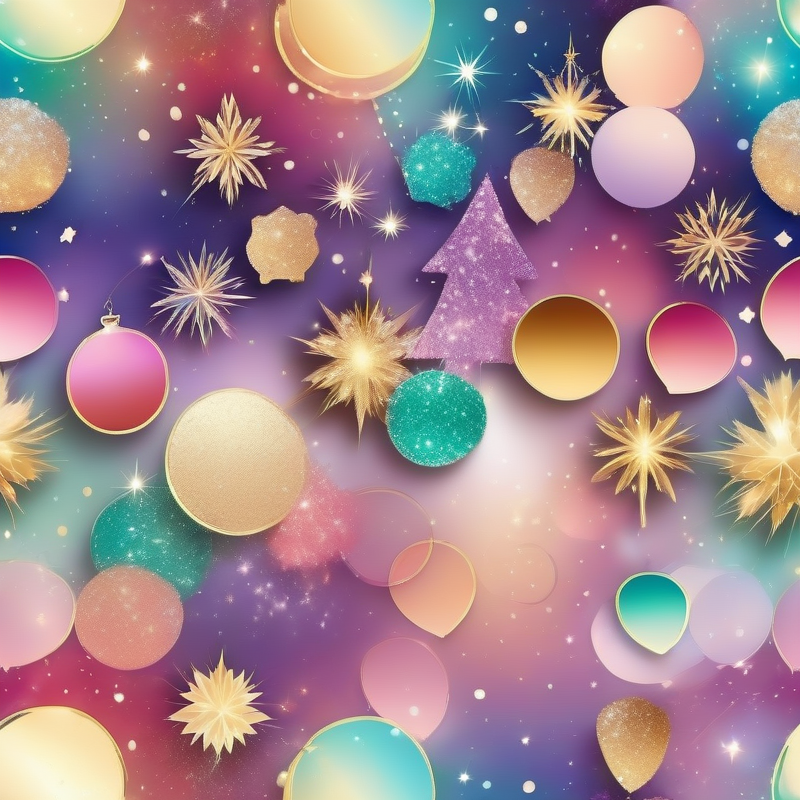


USING PROMPT: New Year symbols arranged neatly, pastel pink and green background, glossy highlights, subtle vignette, postcard, no text


  0%|          | 0/28 [00:00<?, ?it/s]

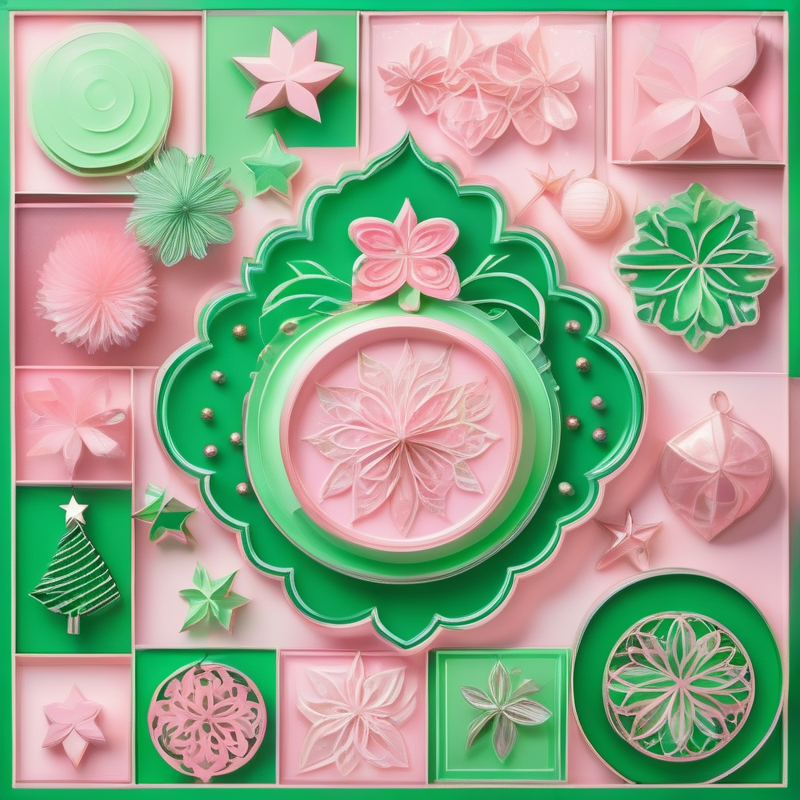


USING PROMPT: New Year main symbol inside a decorative heart or wreath frame, soft lighting, high saturation, clean background, postcard, no text


  0%|          | 0/28 [00:00<?, ?it/s]

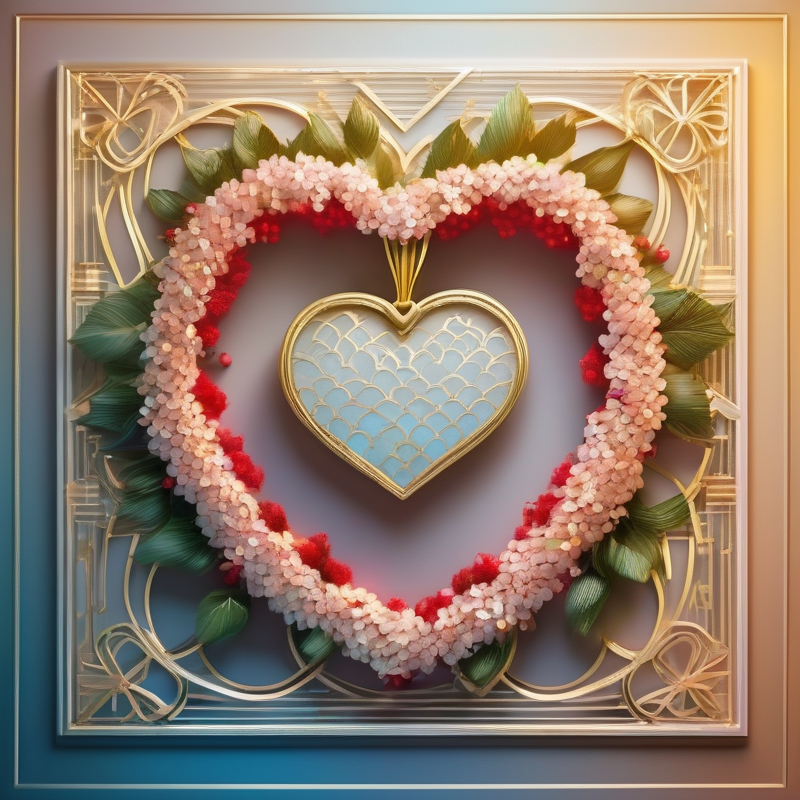

In [8]:
from IPython.display import display

user_text = "Новый год"

pack = rewrite_for_sdxl(user_text)
print("EN topic:", pack["topic_en"])
for i, p in enumerate(pack["prompts"], 1):
    print(f"Prompt {i}: {p}")
print("NEG:", pack["negative"])

for i, p in enumerate(pack["prompts"], 1):
    print("\nUSING PROMPT:", p)
    img = gen(p, f"postcard_{i}.png", negative=pack["negative"], seed=48+i)
    display(img)
